BASELINE

In [22]:
import numpy as np, pandas as pd
import scipy.stats as st

In [29]:
data = pd.read_csv('data.csv')
num_obvs = 100000
# risks per sector
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
#sec_loading maps sector to its risk, t is the threshold for defaults
data['sec_loading'], data['t'] = r[data['sector'].values], st.norm.ppf(data.p)
# 100k monte carlo simulations and len(r)+len(data) risk factors per one sample
factors, sample, vars = np.random.normal(0,1, (num_obvs, len(r)+len(data))), [], []

In [ ]:
for obs in factors:
    # market risk, sector risk and company-specific risk factors
    m_factor, sec_factor, res_factor = obs[0], obs[:len(r)][data.sector.values], obs[len(r):]
    
    ind = r[0]**.5 * m_factor + (data.sec_loading-r[0])**.5 * sec_factor + (1-
                                                                            data.sec_loading)**.5 * res_factor < data.t
    loss = np.zeros((len(data),))
    loss[ind] = data[ind].m + data[ind].d * np.random.standard_t(3, size=sum(ind))
    sample.append(sum(loss))
    vars.append(np.var(loss))

In [ ]:
VaR_base = np.percentile(-np.array(sample), 99.9)
variance_base = np.mean(vars)

In [ ]:
print("Avarage loss varianve:", np.mean(vars))
print("Quantile at order 99.9:", VaR_base)

ENHANCING

In [1]:
import numpy as np, pandas as pd
from scipy.stats import t, norm
from joblib import Parallel, delayed

In [2]:
data = pd.read_csv('data.csv')

num_obvs = 100_000
r = np.array([.295, .49, .41, .415, .338, .64, .403, .476])
sector_indices = data['sector'].values
sec_loading = r[sector_indices]
datat = norm.ppf(data['p'])

In [3]:
def process_obs(obs):
    m_factor = obs[0]
    sec_factor = obs[:len(r)][sector_indices]
    res_factor = obs[len(r):]

    control_variate = (
            r[0]**0.5 * m_factor
            + (sec_loading - r[0])**0.5 * sec_factor
            + (1 - sec_loading)**0.5 * res_factor
    )

    ind = control_variate < datat
    loss = np.zeros(len(data))

    if np.any(ind):
        loss[ind] = data.loc[ind, 'm'].values + data.loc[ind, 'd'].values * np.clip(t.rvs(df=3, size=sum(ind)), -5, 5)

    return np.sum(loss), np.var(loss)

In [4]:
from scipy.stats import genpareto

factors = np.random.normal(0, 1, (num_obvs, len(r) + len(data)))
antithetic_factors = -factors
combined_factors = np.vstack([factors, antithetic_factors])

answers = Parallel(n_jobs=-1, verbose=5)(delayed(process_obs)(obs) for obs in combined_factors)
answers = np.array(answers)

sample_losses = answers[:, 0]
sample_vars = answers[:, 1]

threshold = np.percentile(sample_losses, 99) 
print(f"Threshold for GPD: {threshold}")

excess_losses = sample_losses[sample_losses > threshold] - threshold

shape, loc, scale = genpareto.fit(excess_losses)

p_tail = 0.999 
n_excess = len(excess_losses)
VaR_parametric = threshold + scale / shape * ((num_obvs / n_excess * (1 - p_tail)) ** (-shape) - 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2080 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 7264 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 13600 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 21088 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 29728 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 39520 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 50464 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 62560 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 75808 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 90208 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 105760 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 122464 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 140

Threshold for GPD: 8049.942987813222


In [5]:
print("Avarage loss varianve:", np.mean(sample_vars))
print("Quantile at order 99.9:", VaR_parametric)

Avarage loss varianve: 1346.3433963432474
Quantile at order 99.9: 21442.24059897807


In [10]:
var_999 = np.percentile(-sample_losses, 99.9)
es_999 = np.mean(sample_losses[sample_losses > var_999])
print(f"Expected Shortfall at 99.999%: {es_999:.5f}")

Expected Shortfall at 99.999%: 28151.33866


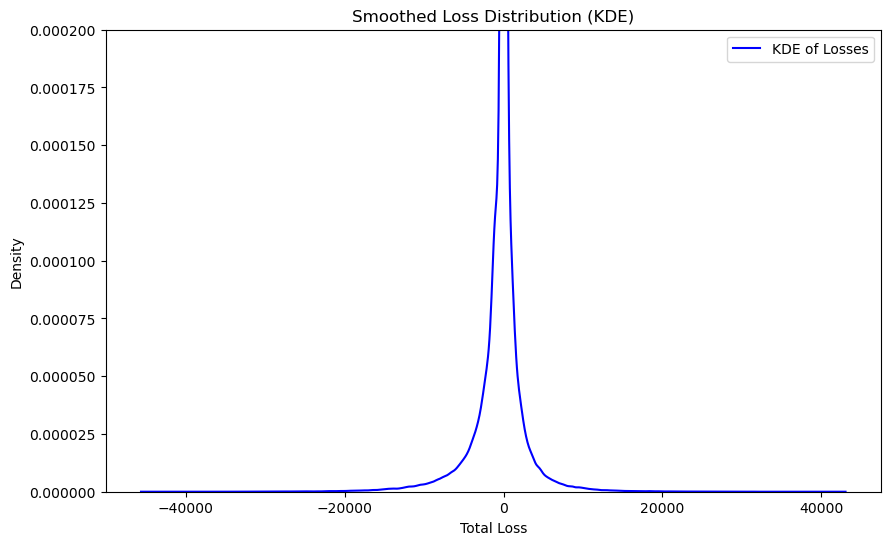

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

losses = np.array(sample_losses)

kde = gaussian_kde(losses)

x_values = np.linspace(min(losses), max(losses), 1000)
kde_values = kde(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, kde_values, color='blue', label='KDE of Losses')
plt.title("Smoothed Loss Distribution (KDE)")
plt.xlabel("Total Loss")
plt.ylim(0, 0.0002)
plt.ylabel("Density")
plt.legend()
plt.show()

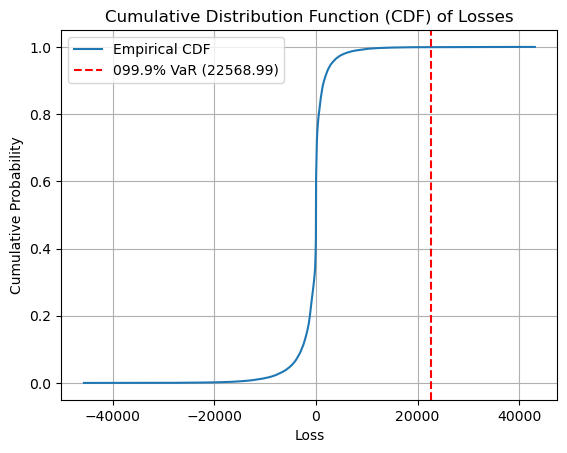

In [14]:
sorted_losses = np.sort(sample_losses)
cdf = np.arange(1, len(sorted_losses)+1) / len(sorted_losses)
plt.plot(sorted_losses, cdf, label="Empirical CDF")
plt.axvline(x=var_999, color='red', linestyle='--', label=f"099.9% VaR ({var_999:.2f})")
plt.title("Cumulative Distribution Function (CDF) of Losses")
plt.xlabel("Loss")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.grid()
plt.show()

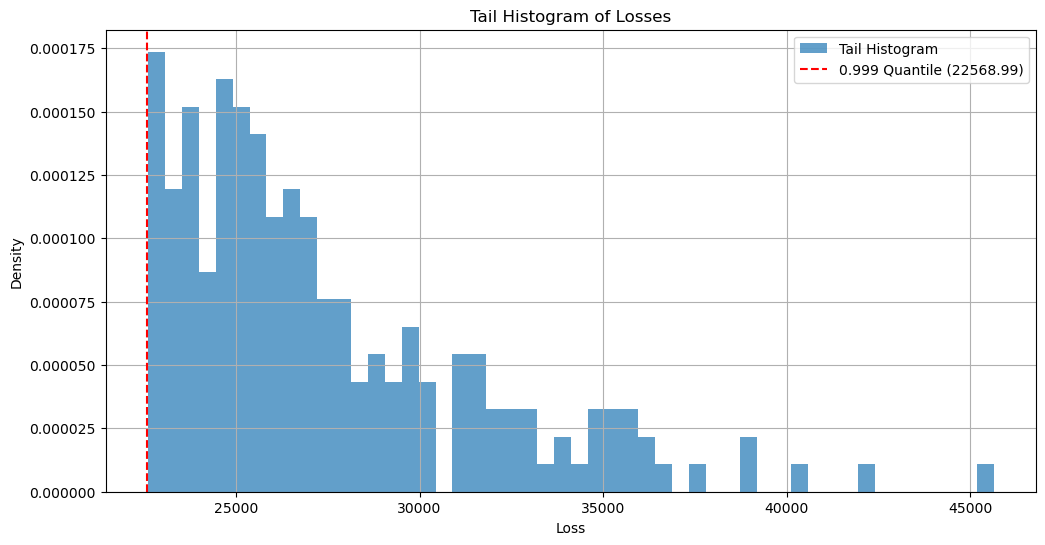

In [18]:
right_tail_losses = -sample_losses[-sample_losses > var_999]
plt.figure(figsize=(12, 6))
plt.hist(right_tail_losses, bins=50, density=True, alpha=0.7, label="Tail Histogram")
plt.title("Tail Histogram of Losses")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.axvline(x=var_999, color='red', linestyle='--', linewidth=1.5, label=f"0.999 Quantile ({var_999:.2f})")
plt.legend()
plt.grid()
plt.show()
